# This code is to check for Urban heat island effect over Brisbane

In [13]:
import healpy as hp


In [2]:
import osmnx as ox
import intake
from easygems import healpix as egh
import healpy as hp
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
from cartopy.io import shapereader as shpreader
from cartopy.feature import ShapelyFeature
import xarray as xr
from pathlib import Path
from rasterio import features
import os

import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.feature as cf
states_provinces = cf.NaturalEarthFeature(
               category='cultural',
               name='admin_1_states_provinces_lines',
               scale='50m',
               facecolor='none')


In [4]:
import xarray as xr
from pathlib import Path


# Gadi location:
* Only zoom 1 and 2 on scratch
* https://github.com/21centuryweather/hackathon-2025-australia-node/blob/main/notebooks/regrid_to_era5.ipynb
* Changing path to scratch

In [ ]:
zoom_lev = '10'
# file = '/scratch/nf33/Healpix_data/UM/data.healpix.PT3H.z' + zoom + '.zarr'
data_2d_z2 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z" + zoom_lev +".zarr" #PT1H is hourly data
ds_2 = xr.open_zarr(data_2d_z2)
# ds2d = xr.open_zarr(data_2d_z2)

In [6]:
ds_2

<xarray.Dataset> Size: 13TB
Dimensions:  (cell: 12582912, time: 10489)
Coordinates:
  * cell     (cell) int64 101MB 0 1 2 3 ... 12582908 12582909 12582910 12582911
    crs      float64 8B ...
  * time     (time) datetime64[ns] 84kB 2020-01-20 ... 2021-04-01
Data variables: (12/26)
    clivi    (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    clt      (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    clwvi    (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    hflsd    (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    hfssd    (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    huss     (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    ...       ...
    rsutcs   (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    sftlf    (cell) float64 101MB dask.array<chunksize=(98304,), meta=np.ndarray>
    tas      (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    ts       (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    uas      (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    vas      (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>

### Function for lat-lon
* https://github.com/21centuryweather/hackathon-2025-australia-node/blob/main/notebooks/regrid_to_era5.ipynb

In [14]:
def get_nn_lon_lat_index(nside, lons, lats):
    lons2, lats2 = np.meshgrid(lons, lats)
    return xr.DataArray(
        hp.ang2pix(nside, lons2, lats2, nest=True, lonlat=True),
        coords=[("lat", lats), ("lon", lons)],
    )

In [9]:
int(zoom_lev)

10

In [34]:
idx = get_nn_lon_lat_index(
    2**int(zoom_lev),
    np.linspace(145, 160, 300), 
    np.linspace(-35, -20, 300)
)

ts_3D = ds_2["ts"].where(ds_2['sftlf']>0).isel(cell=idx)  # this is data conversion

/scratch/nf33/public/miniconda/envs/digital_earths_env/lib/python3.12/site-packages/dask/array/core.py:4988: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


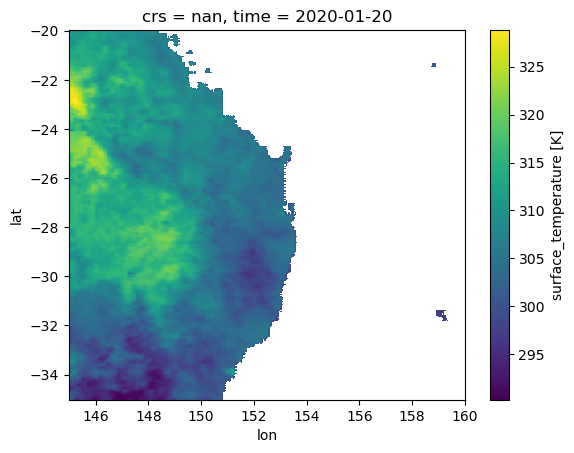

In [35]:
ts_3D[0].plot()

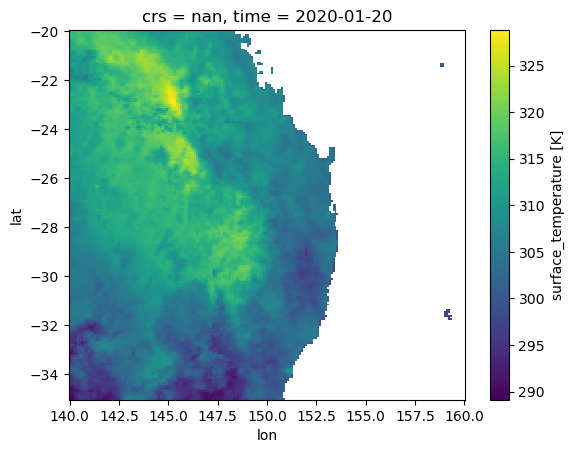

In [17]:
ts_3D[0].plot()

# Working on Brisbane

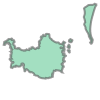

In [18]:
cities = [
    "Brisbane",
    "Sydney",
    "Melbourne",
]
gdf = ox.geocode_to_gdf(cities[0])
gdf.geometry[0]

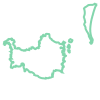

In [58]:
# gdf = ox.geocode_to_gdf('W352332709', by_osmid=True)
polygon = gdf.iloc[0]['geometry']
polygon.boundary

In [75]:
print(gdf['geometry'].geom_type)

0    MultiPolygon
dtype: object


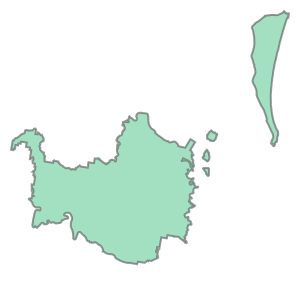

In [19]:
gdf_proj = gdf.to_crs(epsg=3857) 
geom = gdf_proj.geometry[0]
geom

### Getting just BRISBANE MAIN CITY

In [200]:
from shapely.geometry import MultiPolygon, Polygon, Point

In [110]:
# Extract the geometry
geom = gdf.loc[0, 'geometry']

# If it's a MultiPolygon, get the largest one by area
if isinstance(geom, MultiPolygon):
    largest_poly = max(geom.geoms, key=lambda a: a.area)
elif isinstance(geom, Polygon):
    largest_poly = geom
else:
    raise TypeError("Geometry is not a Polygon or MultiPolygon")

# Result: largest polygon
print(largest_poly)

POLYGON ((152.679693 -27.372265, 152.686401 -27.373217, 152.687044 -27.369651, 152.690506 -27.370119, 152.692252 -27.360015, 152.699521 -27.360994, 152.700336 -27.356146, 152.706927 -27.356992, 152.707818 -27.351805, 152.723898 -27.353974, 152.72201 -27.365085, 152.733235 -27.366633, 152.732179 -27.372667, 152.733122 -27.372805, 152.736847 -27.373346, 152.732946 -27.39599, 152.733326 -27.396055, 152.734436 -27.395764, 152.736128 -27.393882, 152.736286 -27.393995, 152.737241 -27.392933, 152.73939 -27.392651, 152.741503 -27.391103, 152.742079 -27.39171, 152.741763 -27.393122, 152.743365 -27.394722, 152.742662 -27.395951, 152.742269 -27.397408, 152.742362 -27.398096, 152.740653 -27.398755, 152.740376 -27.400201, 152.740815 -27.4038, 152.741365 -27.406172, 152.741588 -27.406238, 152.747224 -27.407082, 152.745824 -27.415228, 152.748121 -27.415536, 152.747774 -27.415867, 152.747895 -27.416514, 152.747537 -27.41793, 152.747716 -27.418457, 152.747606 -27.418956, 152.747855 -27.419569, 152.7479

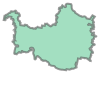

In [122]:
largest_poly

In [123]:
gdf_bne = gpd.GeoDataFrame(index=[0], geometry=[largest_poly], crs=gdf.crs)

In [125]:
gdf_bne.geom_type

0    Polygon
dtype: object

In [126]:
gdf_bne.area

/jobfs/140878142.gadi-pbs/ipykernel_666268/1826141651.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_bne.area


0    0.108854
dtype: float64

In [127]:
gdf_bne_proj = gdf_bne.to_crs(epsg=3857) 
geom_bne = gdf_bne_proj.geometry[0]


In [128]:
geom_bne.area

1520478339.486387

### Getting area of BNE

In [129]:
if geom_bne.geom_type == "Polygon":
    area_km2 = geom_bne.area / 1e6
    print(f"Area: {area_km2:.2f} km²")
if geom_bne.geom_type == "MultiPolygon":
    area_km2 = geom_bne.area / 1e6
    print(f"Area: {area_km2:.2f} km²")
elif geom_bne.geom_type == "LineString":
    length_km = geom_bne.length / 1e3
    print(f"Length: {length_km:.2f} km")

Area: 1520.48 km²


## Plotting data with urban BNE boundary

In [130]:
bne_geometry = gdf_bne.geometry.iloc[0]  # Extract the first geometry

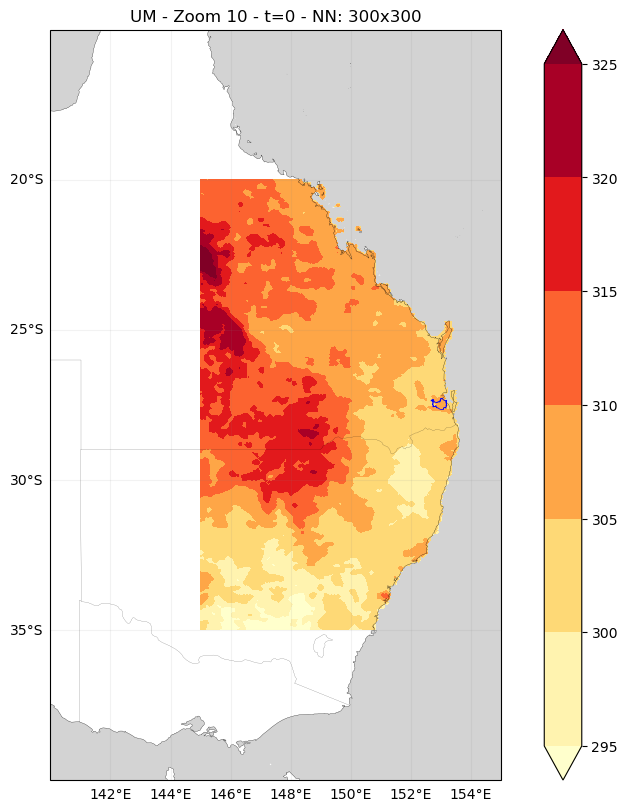

In [131]:
fig=plt.figure(figsize=(10,8), facecolor='w',constrained_layout=True)

ax=plt.subplot(111, projection=ccrs.PlateCarree())

ax.coastlines(linewidth=0.2)
ax.add_feature(states_provinces, linewidth=0.1)
ax.add_feature(cf.OCEAN, facecolor='lightgray')
bne_boundary = ShapelyFeature([bne_geometry], ccrs.PlateCarree(), edgecolor='blue', facecolor='none', linestyle='-', linewidth=0.5)
ax.add_feature(bne_boundary)
ax.set_extent([140,155, -40, -15], ccrs.PlateCarree())
gl=ax.gridlines(alpha=0.1, draw_labels=True, color='gray')
gl.top_labels = False
gl.right_labels = False

cm=ax.contourf(ts_3D.lon, ts_3D.lat, ts_3D[0], cmap='YlOrRd', levels=None,
                     extend='both', transform=ccrs.PlateCarree())
plt.title(f'UM - Zoom {zoom_lev} - t=0 - NN: 300x300')
plt.colorbar(cm)
plt.show()

/scratch/nf33/public/miniconda/envs/digital_earths_env/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/scratch/nf33/public/miniconda/envs/digital_earths_env/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


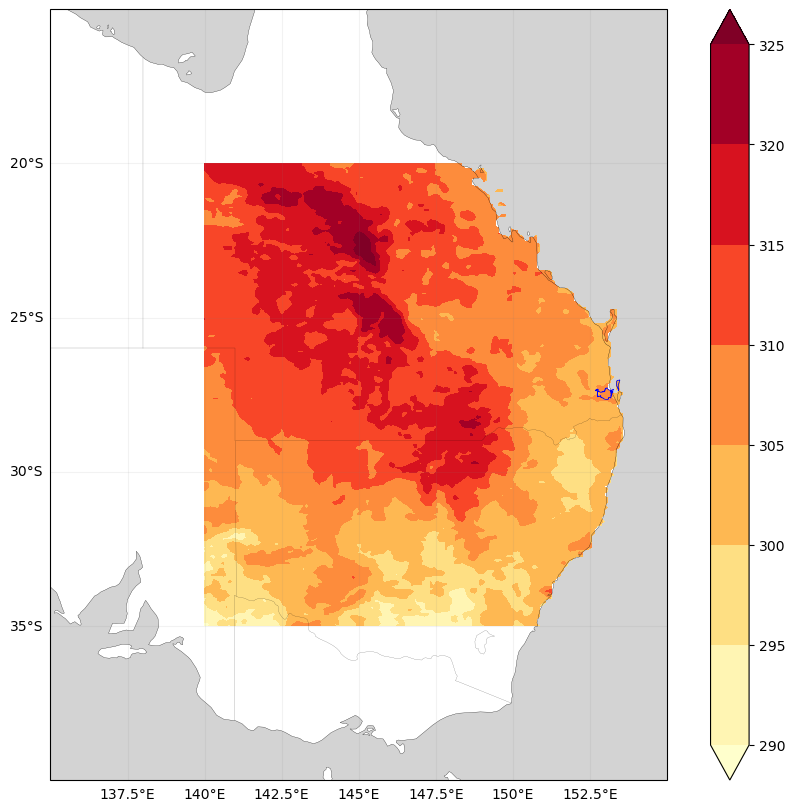

In [23]:
fig=plt.figure(figsize=(10,8), facecolor='w',constrained_layout=True)

ax=plt.subplot(111, projection=ccrs.PlateCarree())

ax.coastlines(linewidth=0.2)
ax.add_feature(states_provinces, linewidth=0.1)
ax.add_feature(cf.OCEAN, facecolor='lightgray')
bne_boundary = ShapelyFeature([bne_geometry], ccrs.PlateCarree(), edgecolor='blue', facecolor='none', linestyle='-', linewidth=0.5)
ax.add_feature(bne_boundary)
ax.set_extent([135,155, -40, -15], ccrs.PlateCarree())
gl=ax.gridlines(alpha=0.1, draw_labels=True, color='gray')
gl.top_labels = False
gl.right_labels = False

cm=ax.contourf(ts_3D.lon, ts_3D.lat, ts_3D[0], cmap='YlOrRd', levels=None,
                     extend='both', transform=ccrs.PlateCarree())
plt.colorbar(cm)
plt.show()

### Testing egh.coordinate thing for lat-lon

In [29]:
ds_z=ds_2.pipe(egh.attach_coords)
ts_z=ds_z["ts"]

ValueError: not enough values to unpack (expected 2, got 1)

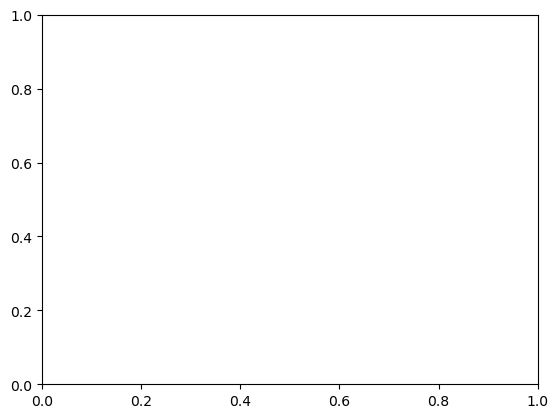

In [31]:
plt.pcolormesh(ts_z.lon, ts_z.lat, ts_z[0])

### Getting mask over the BNE area

In [24]:
ts_3D.rio.write_crs("EPSG:4326", inplace=True)

<xarray.DataArray 'ts' (time: 10489, lat: 200, lon: 200)> Size: 2GB
dask.array<transpose, shape=(10489, 200, 200), dtype=float32, chunksize=(1, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    cell            (lat, lon) int64 320kB 10240168 10240163 ... 6464440 6464433
    crs             float64 8B nan
  * time            (time) datetime64[ns] 84kB 2020-01-20 ... 2021-04-01
  * lat             (lat) float64 2kB -35.0 -34.92 -34.85 ... -20.08 -20.0
  * lon             (lon) float64 2kB 140.0 140.1 140.2 ... 159.8 159.9 160.0
    healpix_nested  int64 8B 0
Attributes:
    STASH:          [1, 0, 24]
    UM_name:        surface_temperature
    healpix_zoom:   10
    long_name:      surface_temperature
    source:         Data from Met Office Unified Model
    standard_name:  surface_temperature
    um_version:     13.5
    units:          K

In [132]:
tmp = ts_3D.rio.write_crs("EPSG:4326", inplace=True)
tmp = tmp.rename({'lon':'x', 'lat':'y'})

gdf = gdf.to_crs(tmp.rio.crs)

mask = features.rasterize(
    [(geom, 1) for geom in gdf_bne["geometry"]],
    out_shape=tmp.rio.shape,
    transform=tmp.rio.transform(),
    fill=0,
    dtype='uint8'
)

mask_da = xr.DataArray(mask, dims=("lat", "lon"), coords={"lat": tmp.y.values, "lon": tmp.x.values})

ts_BNE = ts_3D.where(mask_da == 1)   # this is masking 

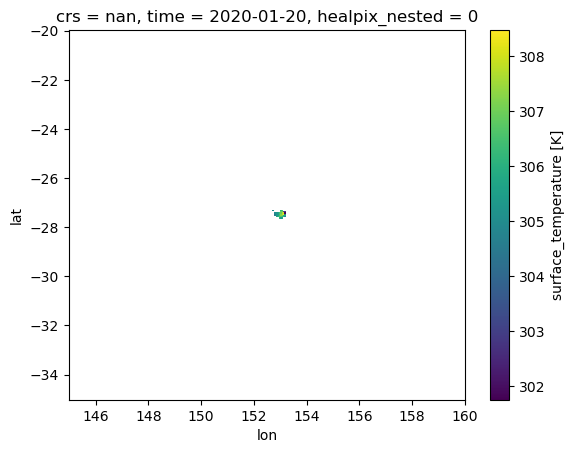

In [133]:
ts_BNE[0].plot()

In [48]:
ts_BNE.time#.plot()

<xarray.DataArray 'time' (time: 10489)> Size: 84kB
array(['2020-01-20T00:00:00.000000000', '2020-01-20T01:00:00.000000000',
       '2020-01-20T02:00:00.000000000', ..., '2021-03-31T22:00:00.000000000',
       '2021-03-31T23:00:00.000000000', '2021-04-01T00:00:00.000000000'],
      shape=(10489,), dtype='datetime64[ns]')
Coordinates:
    crs             float64 8B nan
  * time            (time) datetime64[ns] 84kB 2020-01-20 ... 2021-04-01
    healpix_nested  int64 8B 0

## Using 1pm local time as max temperature time
* BNE time is 10 hours ahead
* Taking 3pm UTC - 15 months of data
* Could account for daylight savings
* Could google sunrise and sunset times - and take avg of max and min during day and night

In [134]:
ts_BNE_1pm=ts_BNE[3:][::24]

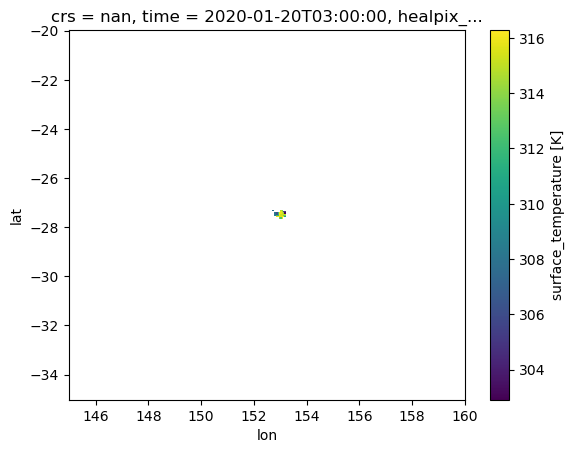

In [135]:
ts_BNE_1pm[0].plot()

In [136]:
ts_3D_1pm=ts_3D[3:][::24]

## Get buffer zone and area around it

In [163]:
#geom_bne.length, geom_bne.area#, geom_bne.bounds, geom_bne.boundary

In [164]:
#print(geom_bne.boundary)

In [157]:
#(geom_bne.centroid.x), (geom_bne.centroid.y)

(17030233.8095743, -3183609.5139612383)

### Getting centroid of BNE and distance to exteriors from the largest_poly defined above

In [165]:
centroid_bne=largest_poly.centroid

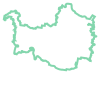

In [176]:
largest_poly.exterior#.x

In [177]:
from geopy.distance import geodesic

In [178]:
# Compute max radius from centroid to boundary
boundary_coords = np.array(largest_poly.exterior.coords)
distances_m = [
    geodesic((centroid_bne.y, centroid_bne.x), (lat, lon)).meters
    for lon, lat in boundary_coords  # coords = (lon, lat)
]
radius_m = max(distances_m)
radius_km = radius_m / 1000
center_lat, center_lon = centroid_bne.y, centroid_bne.x


In [180]:
radius_km, center_lon, center_lat

(33.13785429486232, 152.98519075277335, -27.48021866411661)

### Function to set a circle of radius from centroid

In [183]:
def create_circle(center_lat, center_lon , radius_km, num_points=360):
    angles = np.linspace(0, 360, num_points)
    circle_lats, circle_lons = [], []
    for angle in angles:
        dest = geodesic(kilometers=radius_km).destination((center_lat, center_lon), angle)
        circle_lats.append(dest.latitude)
        circle_lons.append(dest.longitude)
    return circle_lons, circle_lats

circle_lons, circle_lats = create_circle(center_lat, center_lon, radius_km)
circle_polygon = Polygon(zip(circle_lons, circle_lats))  # For masking


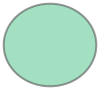

In [184]:
circle_polygon

In [189]:
ts_3D_1pm['lat']

<xarray.DataArray 'lat' (lat: 300)> Size: 2kB
array([-35.      , -34.949833, -34.899666, ..., -20.100334, -20.050167,
       -20.      ], shape=(300,))
Coordinates:
    crs             float64 8B nan
  * lat             (lat) float64 2kB -35.0 -34.95 -34.9 ... -20.1 -20.05 -20.0
    healpix_nested  int64 8B 0

### Get lat lon of data in land

In [190]:
lat_2d, lon_2d = xr.broadcast(ts_3D_1pm['lat'], ts_3D_1pm['lon'])

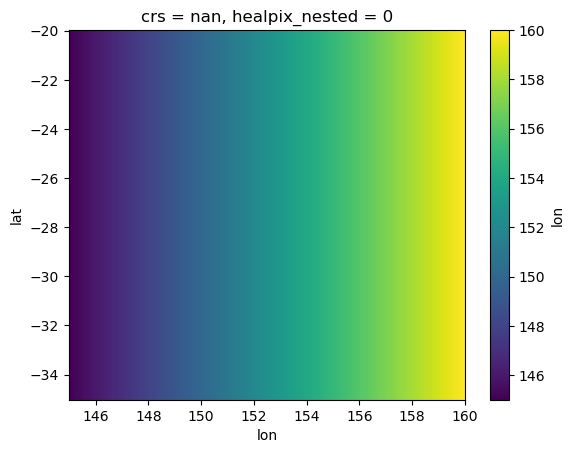

In [193]:
lon_2d.plot()

### This below does not work as it is 2D

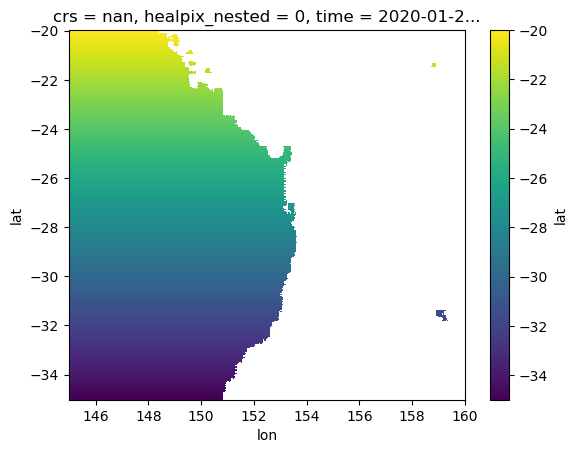

In [197]:
# land_lons = lon_2d.where(~np.isnan(ts_3D_1pm[0]))
# land_lats = lat_2d.where(~np.isnan(ts_3D_1pm[0]))
# land_lats.plot()

In [206]:
mask_land_2d=~np.isnan(ts_3D_1pm[0].values)
mask_land_2d

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]], shape=(300, 300))

In [208]:
land_lons = lon_2d.values[mask_land_2d]
land_lats = lat_2d.values[mask_land_2d]
land_lats

array([-35., -35., -35., ..., -20., -20., -20.], shape=(42052,))

### Create shapely Point series

In [209]:
points = gpd.GeoSeries([Point(lon, lat) for lon, lat in zip(land_lons, land_lats)], crs="EPSG:4326")
points

0              POINT (145 -35)
1        POINT (145.05017 -35)
2        POINT (145.10033 -35)
3         POINT (145.1505 -35)
4        POINT (145.20067 -35)
                 ...          
42047    POINT (148.16054 -20)
42048     POINT (148.2107 -20)
42049    POINT (148.26087 -20)
42050    POINT (148.31104 -20)
42051     POINT (148.3612 -20)
Length: 42052, dtype: geometry

### Step 4: Identify those in circle but not in BNE ---

In [210]:
inside_circle = points.within(circle_polygon)
outside_bne = ~points.within(largest_poly)
highlight_mask = inside_circle & outside_bne
highlight_points = points[highlight_mask]

### Step 6: Highlight points inside BNE

In [211]:
inside_bne = points.within(largest_poly)
highlight_inside_bne = points[inside_bne]

### Plot everything

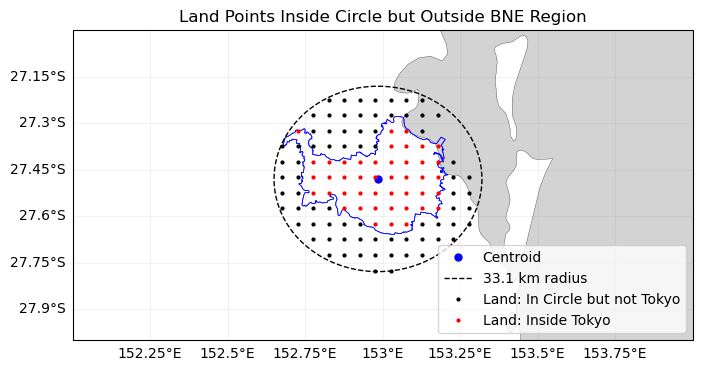

<Figure size 640x480 with 0 Axes>

In [215]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines(linewidth=0.2)
ax.add_feature(states_provinces, linewidth=0.1)
ax.add_feature(cf.OCEAN, facecolor='lightgray')
bne_boundary = ShapelyFeature([bne_geometry], ccrs.PlateCarree(), edgecolor='blue', facecolor='none', linestyle='-', linewidth=0.5)
ax.add_feature(bne_boundary)
ax.set_extent([152,154, -28, -27], ccrs.PlateCarree())
gl=ax.gridlines(alpha=0.1, draw_labels=True, color='gray')
gl.top_labels = False
gl.right_labels = False

# Tokyo boundary
ax.add_feature(bne_boundary)

# Centroid + circle
ax.plot(centroid_bne.x, centroid_bne.y, 'bo', markersize=5,
        transform=ccrs.PlateCarree(), label='Centroid')
ax.plot(circle_lons, circle_lats, 'k--', linewidth=1.0, label=f'{radius_km:.1f} km radius')

# Highlighted points outside Tokyo but inside circle
ax.plot(highlight_points.x, highlight_points.y, 'k.', markersize=4, label='Land: In Circle but not Tokyo')

# Highlighted points inside Tokyo
ax.plot(highlight_inside_bne.x, highlight_inside_bne.y, 'r.', markersize=4, label='Land: Inside Tokyo')



# Legend and title
ax.legend(loc='lower right')
plt.title("Land Points Inside Circle but Outside BNE Region")
plt.show()

os.chdir('/home/561/dc5055/WCRP_HK25/')
plt.savefig('BNE_UM_z10_data_points.png', dpi=300, bbox_inches='tight')

# Prior to 2025/05/12: Online version

In [3]:
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")["online"]
list(cat)

['ERA5',
 'IR_IMERG',
 'JRA3Q',
 'MERRA2',
 'casesm2_10km_nocumulus',
 'icon_d3hp003',
 'icon_d3hp003aug',
 'icon_d3hp003feb',
 'icon_ngc4008',
 'ifs_tco3999-ng5_deepoff',
 'ifs_tco3999-ng5_rcbmf',
 'ifs_tco3999-ng5_rcbmf_cf',
 'nicam_gl11',
 'scream-dkrz',
 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9_TBv1p2',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3']

In [4]:
from pathlib import Path
import glob
import datetime
from scipy.stats import mannwhitneyu
# from xarrayMannKendall import *
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cf
states_provinces = cf.NaturalEarthFeature(
               category='cultural',
               name='admin_1_states_provinces_lines',
               scale='50m',
               facecolor='none')
import string  
lower = list(string.ascii_lowercase)  


In [5]:
import xarray as xr
from pathlib import Path
import pandas as pd

In [6]:
pd.DataFrame(cat["um_glm_n2560_RAL3p3"].describe()["user_parameters"])

,name,description,type,allowed,default
0,time,time resolution of the dataset,str,"[PT1H, PT3H]",PT1H
1,zoom,zoom resolution of the dataset,int,"[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",8


In [14]:
zoom_lev=10
ds_z = cat["um_glm_n2560_RAL3p3"](zoom=zoom_lev).to_dask() 
ds_z=ds_z.pipe(egh.attach_coords)
ds_z

ServerDisconnectedError: Server disconnected

In [ ]:
ts_z=ds_z["ts"]
ts_z=ts_z.where((ts_z["lon"]>110)&(ts_z["lon"]<160)).where((ts_z["lat"]>-50)&(ts_z["lat"]<0))
ts_z

### Getting to Brisbane

In [ ]:
import osmnx as ox


cities = [
    "Brisbane",
    "Sydney",
    "Melbourne",
]
gdf = ox.geocode_to_gdf(cities)
gdf.geometry[0]

In [4]:
pd.DataFrame(cat["um_glm_n2560_RAL3p3"].describe()["user_parameters"])

,name,description,type,allowed,default
0,time,time resolution of the dataset,str,"[PT1H, PT3H]",PT1H
1,zoom,zoom resolution of the dataset,int,"[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",8
